# Multiple Stripe Analysis on MDOF System

## Introduction

This Jupyter Notebook outlines a structured workflow for conducting nonlinear time-history analysis (NLTHA), specifically multiple stripe analysis, on multi-degree-of-freedom (MDOF) structural models. The analysis uses a set of spectrally matched ground-motion records, selected based on classical probabilistic seismic hazard and disaggregation analysis for a site in L'Aquila.

Ground-motion records were selected for nine return periods: 22, 42, 72, 140, 250, 475, 975, 2475, and 4975 years. These records were chosen using the Conditional Mean Spectrum (CMS) method, with the average spectral acceleration at 0.3 seconds used as the intensity measure.

The selected ground-motion records can be found in the "Records" folder. Each return period has its own folder containing a "Selected.PDF" file, which includes the conditional spectra showing the target median, variability, and the selected records.

The main goals of this notebook:

1. **Calibrate MDOF models based on single-degree-of-freedom (SDOF) oscillator capacity**: Calibrate storey-based force-deformation relationships using SDOF capacity curve definition (spectral displacement-spectral acceleration) based on the methodology of Lu et al. (2020) and other modifications to account for distinct response typologies (i.e., bilinear, trilinear and quadrilinear backbone definitions)

2. **Compile and construct MDOF Models in OpenSees**: Define and assemble MDOF models by specifying essential structural properties, including:
   - Mass, heights, fundamental period, etc.
   - Nonlinear response characteristics at each degree of freedom

3. **Run Nonlinear Time-History Analysis (NLTHA) in OpenSees**: Simulate the dynamic response of MDOF structures under time-dependent inputs, such as ground motion records, to realistically assess structural behavior and response metrics (e.g., peak storey drifts, peak floor accelerations) under loading conditions and extract critical response metrics and model information.

4. **Fragility Analysis**: Postprocess multiple stripe analysis results using maximum likelihood estimation (MLE) to directly derive fragility functions. This approach estimates the median seismic intensity and total dispersion associated with specified demand thresholds (e.g., maximum interstorey drift), and defines the probability of exceeding damage states as a function of increasing ground shaking intensity.

5. **Vulnerability Analysis**: Integrate fragility functions with consequence models (i.e., damage-to-loss models) to determine the continuous relationship between a decision variable and increasing levels of ground-shaking.

The notebook provides a step-by-step guide, covering each phase from MDOF model calibration, setup to input parameter configuration, analysis execution, and detailed results extraction and postprocessing. Users should have some familiarity with python scripts, structural dynamics, computational modeling, and performance-based earthquake engineering to fully benefit from this material.

---

## References

[1] Jalayer, F. and Cornell, C.A. (2009), Alternative non-linear demand estimation methods for probability-based seismic assessments. Earthquake Engng. Struct. Dyn., 38: 951-972. https://doi.org/10.1002/eqe.876

[2] Baker JW. Efficient Analytical Fragility Function Fitting Using Dynamic Structural Analysis. Earthquake Spectra. 2015;31(1):579-599. doi:10.1193/021113EQS025M

[3] Lu X, McKenna F, Cheng Q, Xu Z, Zeng X, Mahin SA. An open-source framework for regional earthquake loss estimation using the city-scale nonlinear time history analysis. Earthquake Spectra. 2020;36(2):806-831. doi:10.1177/8755293019891724

## Initialize Libraries ##

In [2]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the classes necessary for structural analysis
from openquake.vmtk.units         import units              # oq-vtmk units class
from openquake.vmtk.calibration   import calibrate_model    # oq-vmtk sdof-to-mdof calibration class
from openquake.vmtk.modeller      import modeller           # oq-vmtk numerical modelling class
from openquake.vmtk.postprocessor import postprocessor      # oq-vtmk postprocessing class
from openquake.vmtk.plotter       import plotter            # oq-vmtk plotting class
from openquake.vmtk.utilities     import sorted_alphanumeric, import_from_pkl, export_to_pkl # oq-vmtk utility class

## Define Directories ##

In [3]:
# Define the directory of the ground-motion records
gm_directory  = './Records'            

# Define the main output directory
nrha_directory = './Output'  
os.makedirs(nrha_directory, exist_ok=True)

# Define directory for temporary analysis outputs: it is used to store temporary .txt files used as accelerations recorders
temp_nrha_directory = os.path.join(nrha_directory,'temp')
os.makedirs(temp_nrha_directory, exist_ok=True)

## Required Input Parameters ##

### Modelling Input Parameters ###

In [4]:
# Number of storeys
number_storeys = 3

# Relative floor heights list
floor_heights = [2.80, 2.80, 2.80]

# First-mode based participation factor
gamma = 1.25

# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
sdof_capacity = np.array([[4.46E-02,1.89E-01], 
                          [1.14E+00,1.15E+00]]).T
# Frame flag
isFrame = False

# Soft-storey mechanism flag
isSOS = False

# Degradation flag 
mdof_degradation = True

# Inherent damping 
mdof_damping = 0.03

### Fragility and Vulnerability Input Parameters ###

In [9]:
# Damage thresholds (maximum peak storey drift values in rad)
damage_thresholds    =  [0.0050, 0.0100, 0.0150, 0.030] 

# Define consequence model to relate structural damage to a decision variable (i.e., expected loss ratio) 
consequence_model = [0.05, 0.20, 0.60, 1.00] # damage-to-loss ratios

## Multiple Stripe Analysis ##

Multiple Stripe Analysis (MSA) involves subjecting a structural model to suites of ground motion records that are scaled to specific intensity measure (IM) levels, called "stripes", across a range of seismic intensities. Often, records are spectrally matched or selected using the Conditional Mean Spectrum (CMS) approach. Thus, at each stripe (IM level), multiple spectrally compatible records are used to account for record-to-record variability. The method provides statistical distributions of response at each demand-based damage threshold, useful for fragility assessment via methods like Maximum Likelihood Estimation (MLE). The analysis results are then used to evaluate the probability of exceeding certain performance thresholds (e.g., drift limits), enabling the construction of fragility functions.

### Multiple Stripe Analysis - Part 1: Calibrate MDOF Model based on SDOF Capacity Definition ###

#### The calibration function (calibrate_model) requires five input arguments:
1. Number of storeys
2. First-mode transformation factor (gamma)
3. The capacity array of the single degree-of-freedom oscillator
4. Boolean flag whether the lateral load-resisting system for the considered building class is moment-resisting frames or braced frames (or not)
5. Boolean flag whether the building class expects a soft-storey mechanism to be activated (or not)
#### The calibration function (calibrate_model) returns four output variables:
1. The floor mass array to be assigned to the MDOF model generator (floor_masses)
2. The storey deformation (in m) capacity to be assigned to the MDOF model generator (storey_disps)
3. The acceleration capacity (in g) to be assigned to the MDOF model generator (storey_forces)
4. The considered mode shape (mdof_phi)

The mass of each floor (in tonnes): [0.3953083755249415, 0.3953083755249415, 0.29648128164370613]
The first-mode shape used for calibration: [0.46774089 0.82856649 1.        ]


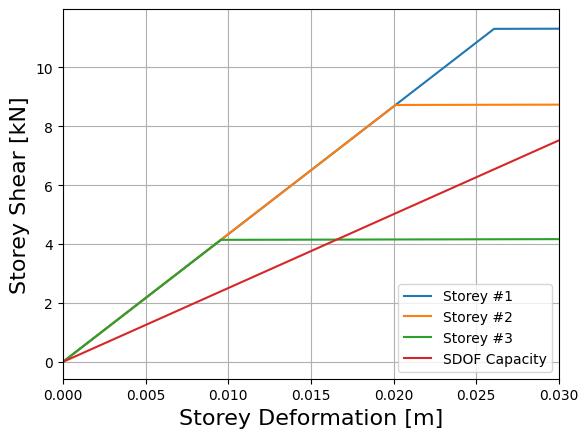

In [8]:
# Calibrate the model using the Lu et al. (2020) method
floor_masses, storey_disps, storey_forces, mdof_phi = calibrate_model(number_storeys, gamma, sdof_capacity, isFrame, isSOS)

print('The mass of each floor (in tonnes):', floor_masses)
print('The first-mode shape used for calibration:', mdof_phi)

# Plot the capacities to visualise the outcome of the calibration
for i in range(storey_disps.shape[0]):
   plt.plot(np.concatenate(([0.0], storey_disps[i,:])), np.concatenate(([0.0], storey_forces[i,:]*9.81)), label = f'Storey #{i+1}')
plt.plot(np.concatenate(([0.0], sdof_capacity[:,0])), np.concatenate(([0.0], sdof_capacity[:,1]*9.81)), label = 'SDOF Capacity')
plt.xlabel('Storey Deformation [m]', fontsize= 16)
plt.ylabel('Storey Shear [kN]', fontsize = 16)
plt.legend(loc = 'lower right')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xlim([0.00, 0.03])
plt.show()

### Multiple Stripe Analysis - Part 2: Setting Up, Running and Exporting Analysis ###

In [ ]:
# Initialise MDOF storage lists
conv_index_list = []               # List for convergence indices
peak_disp_list  = []               # List for peak floor displacement (returns all peak values along the building height)
peak_drift_list = []               # List for peak storey drift (returns all peak values along the building height)
peak_accel_list = []               # List for peak floor acceleration (returns all peak values along the building height)
max_peak_drift_list = []           # List for maximum peak storey drift (returns the maximum value) 
max_peak_accel_list = []           # List for maximum peak floor acceleration (returns the maximum value)

# Loop over ground-motion records, compile MDOF model and run NLTHA
gmrs = sorted_alphanumeric(os.listdir(os.path.join(gm_directory,'acc')))                         # Sort the ground-motion records alphanumerically
dts  = sorted_alphanumeric(os.listdir(os.path.join(gm_directory,'dts')))                         # Sort the ground-motion time-step files alphanumerically

# Run the analysis
for i in range(len(gmrs)):
    ### Print post-processing iteration
    print('================================================================')
    print('============== Analysing: {:d} out of {:d} =================='.format(i+1, len(gmrs)))
    print('================================================================')

    ### Compile the MDOF model    
    model = modeller(number_storeys,
                     floor_heights,
                     floor_masses,
                     storey_disps,
                     storey_forces*units.g,
                     mdof_degradation)                                                                # Initialise the class (Build the model)
    
    model.compile_model()                                                                             # Compile the MDOF model
    
    if i==0:
        model.plot_model()                                                                            # Visualise the model (only on first iteration)        
    model.do_gravity_analysis()                                                                       # Do gravity analysis

    if number_storeys == 1:
        num_modes = 1
    else:
        num_modes = 3
    T, phi = model.do_modal_analysis(num_modes = num_modes)                                           # Do modal analysis and get period of vibration (Essential step for running NLTHA)

    ### Define ground motion objects
    fnames = [os.path.join(gm_directory,'acc',f'{gmrs[i]}')]                                          # Ground-motion record names
    fdts   =  os.path.join(gm_directory,'dts',f'{dts[i]}')                                            # Ground-motion time-step names 
    dt_gm = pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[1]-\
            pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[0]           # Ground-motion time-step
    t_max = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].iloc[-1]                                  # Ground-motion duration
    
    ### Define analysis params and do NLTHA
    dt_ansys = dt_gm                                                            # Set the analysis time-step
    sf = units.g                                                                # Set the scaling factor (if records are in g, a scaling factor of 9.81 m/s2 must be used to be consistent with opensees) 
    control_nodes, conv_index, peak_drift, peak_accel, max_peak_drift, max_peak_drift_dir, max_peak_drift_loc, max_peak_accel, max_peak_accel_dir, max_peak_accel_loc, peak_disp = model.do_nrha_analysis(fnames, 
                                                                                                                                                                                                          dt_gm, 
                                                                                                                                                                                                          sf, 
                                                                                                                                                                                                          t_max, 
                                                                                                                                                                                                          dt_ansys,
                                                                                                                                                                                                          temp_nrha_directory,
                                                                                                                                                                                                          pflag=False,
                                                                                                                                                                                                          xi = mdof_damping)

    ### Store the analysis
    conv_index_list.append(conv_index)
    peak_drift_list.append(peak_drift)
    peak_accel_list.append(peak_accel)
    peak_disp_list.append(peak_disp)
    max_peak_drift_list.append(max_peak_drift)
    max_peak_accel_list.append(max_peak_accel)

# Remove the temporary directory
shutil.rmtree(f'{temp_nrha_directory}')

# Store the analysis results in a dictionary
ansys_dict = {}
labels = ['T','control_nodes', 'conv_index_list',
          'peak_drift_list','peak_accel_list',
          'max_peak_drift_list', 'max_peak_drift_dir_list', 
          'max_peak_drift_loc_list','max_peak_accel_list',
          'max_peak_accel_dir_list','max_peak_accel_loc_list',
          'peak_disp_list']

for i, label in enumerate(labels):
    ansys_dict[label] = vars()[f'{label}']
# Export the analysis output variable to a pickle file using the "export_to_pkl" function from "utilities"
export_to_pkl(os.path.join(nrha_directory,'ansys_out.pkl'), ansys_dict) 

print('ANALYSIS COMPLETED!')